In [2]:
import jupyter_black

import os, shutil
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from PIL import Image

import sys

if not "/usr/src" in sys.path:
    sys.path.append("/usr/src")

jupyter_black.load()

In [4]:
# Custom modules
from dataset import create_cell_dataset, augmentation_cells
from unet import UNet
from diffusion import Diffusion
from utils.diffusion import show_samples, logging

In [5]:
# Dirs
cell_dir = "/usr/src/separated_cells"
new_cell_dir = "/usr/src/separated_cells_new"

In [ ]:
augmentation_cells(cell_dir, new_cell_dir)

In [6]:
cell_dataset = create_cell_dataset(new_cell_dir)

train_size = 7540
test_size = 100

image_size = 64
channels = 1
batch_size = 70
device = "cuda" if torch.cuda.is_available() else "cpu"

train_dataset, test_dataset = random_split(cell_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

# train_loader = DataLoader(cell_dataset, batch_size=batch_size, shuffle=True)

In [5]:
model = UNet(
    img_dim=image_size,
    img_channels=channels,
    in_channels=32,
    channel_mults=(1, 2, 4, 8),
)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [7]:
timesteps = 400
diffusion = Diffusion(timesteps)

In [7]:
epochs = 20
loss_progress = []
log_interval = len(train_loader) // 4
log_path = "logging_cells"
n_log_samples = 10

if os.path.isdir(log_path):
    shutil.rmtree(log_path)

for epoch in range(epochs):
    print(f"----- Epoch {epoch + 1} -----")
    for step, batch in enumerate(train_loader):
        optimizer.zero_grad()

        batch_size = batch.shape[0]
        batch = batch.to(device)

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        loss = diffusion.p_losses(model, batch, t, loss_type="huber")
        loss_progress.append(loss.item())

        if step % log_interval == 0:
            print("Loss:", loss.item())

        loss.backward()
        optimizer.step()

    logging(log_path, diffusion, model, epoch, n_log_samples, image_size, channels)

torch.save(model, f"denoise_model_{epochs}_epochs.pt")

----- Epoch 1 -----
Loss: 0.6421410441398621
Loss: 0.11273760348558426
Loss: 0.046084415167570114
Loss: 0.032575517892837524


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 2 -----
Loss: 0.03881632536649704
Loss: 0.03232688084244728
Loss: 0.027737658470869064
Loss: 0.020771315321326256


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 3 -----
Loss: 0.01993429847061634
Loss: 0.02485606260597706
Loss: 0.02014879509806633
Loss: 0.022888947278261185


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 4 -----
Loss: 0.018297191709280014
Loss: 0.016289224848151207
Loss: 0.015361241064965725
Loss: 0.015375704504549503


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 5 -----
Loss: 0.020190369337797165
Loss: 0.014933690428733826
Loss: 0.015487140975892544
Loss: 0.014526307582855225


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 6 -----
Loss: 0.015611395239830017
Loss: 0.010236389003694057
Loss: 0.01670651137828827
Loss: 0.021346038207411766


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 7 -----
Loss: 0.01655273698270321
Loss: 0.019574256613850594
Loss: 0.013935639522969723
Loss: 0.01672092266380787


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 8 -----
Loss: 0.012828299775719643
Loss: 0.01837429590523243
Loss: 0.011937238276004791
Loss: 0.013024319894611835


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 9 -----
Loss: 0.01520636584609747
Loss: 0.013660738244652748
Loss: 0.014315921813249588
Loss: 0.012087457813322544


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 10 -----
Loss: 0.019078582525253296
Loss: 0.014144212007522583
Loss: 0.011703530326485634
Loss: 0.014864359982311726


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 11 -----
Loss: 0.01476069912314415
Loss: 0.012326673604547977
Loss: 0.01202290691435337
Loss: 0.008994592353701591


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 12 -----
Loss: 0.012242020107805729
Loss: 0.012018401175737381
Loss: 0.013597176410257816
Loss: 0.012000433169305325


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 13 -----
Loss: 0.008881689980626106
Loss: 0.013313314877450466
Loss: 0.011125198565423489
Loss: 0.012652238830924034


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 14 -----
Loss: 0.018333675339818
Loss: 0.011587020009756088
Loss: 0.01149923074990511
Loss: 0.017036767676472664


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 15 -----
Loss: 0.014079852029681206
Loss: 0.006883759051561356
Loss: 0.012585864402353764
Loss: 0.012770474888384342


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 16 -----
Loss: 0.009385203942656517
Loss: 0.01697038859128952
Loss: 0.014035360887646675
Loss: 0.009146004915237427


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 17 -----
Loss: 0.013542776927351952
Loss: 0.008603248745203018
Loss: 0.009856974706053734
Loss: 0.011443058028817177


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 18 -----
Loss: 0.009366774931550026
Loss: 0.010988264344632626
Loss: 0.009330963715910912
Loss: 0.009965643286705017


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 19 -----
Loss: 0.01287015900015831
Loss: 0.012835688889026642
Loss: 0.012649737298488617
Loss: 0.010271618142724037


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

----- Epoch 20 -----
Loss: 0.013386872597038746
Loss: 0.011354942806065083
Loss: 0.009555567987263203
Loss: 0.0145127447322011


sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
model = torch.load("denoise_model_20_epochs.pt")
model.eval()

sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

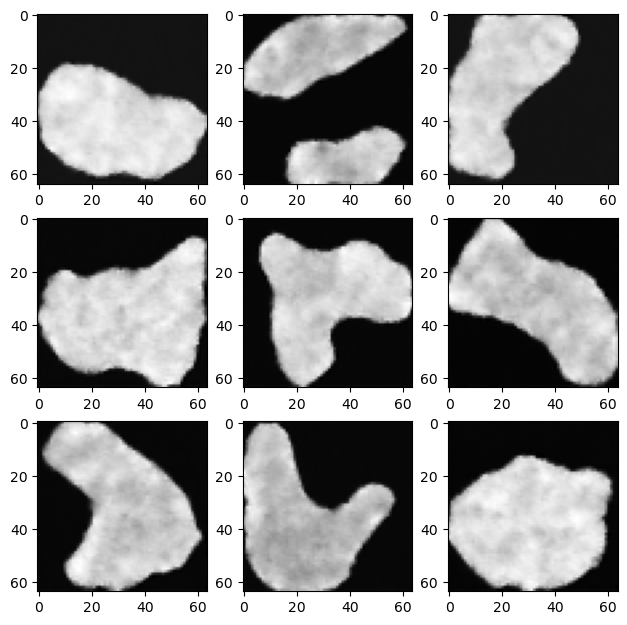

In [11]:
samples = show_samples(9, diffusion, model, image_size, channels)

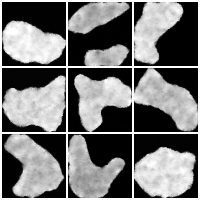

In [12]:
# Cute grid of generated samples :3

samples_T = torch.clamp(torch.tensor(samples[-1]), -1, 1)
samples_T = (samples_T + 1) / 2

grid = make_grid(samples_T, nrow=3, pad_value=1)
grid = transforms.ToPILImage()(grid)
grid.show()

In [20]:
# from utils.diffusion import count_fid_metric
from torchmetrics.image.fid import FrechetInceptionDistance


def count_fid_metric(dataloader, diffusion, model, image_size, channels, n_feature):
    """Compute the FID metric for evaluation of the diffusion models"""

    real_img = next(iter(dataloader))
    n_samples, channels = real_img.shape[0], real_img.shape[1]
    real_img = (real_img + 1) / 2 * 255
    if channels != 3:
        real_img = real_img.byte().repeat(1, 3, 1, 1)

    samples = diffusion.sample(
        model, image_size=image_size, batch_size=n_samples, channels=channels
    )[-1]
    samples = torch.clamp(torch.tensor(samples), -1, 1)
    samples = (samples + 1) / 2 * 255
    if channels != 3:
        samples = samples.byte().repeat(1, 3, 1, 1)

    if isinstance(n_feature, int):
        n_feature = [n_feature]

    metric = []
    for feature in n_feature:
        fid = FrechetInceptionDistance(feature=feature)
        fid.update(real_img, real=True)
        fid.update(samples, real=False)
        metric.append(fid.compute())
    return metric


print(
    count_fid_metric(
        test_loader, diffusion, model, image_size, channels, [64, 192, 768, 2048]
    )
)

sampling loop time step:   0%|          | 0/400 [00:00<?, ?it/s]

[tensor(4.6830), tensor(19.3445), tensor(1.6534), tensor(263.3688)]


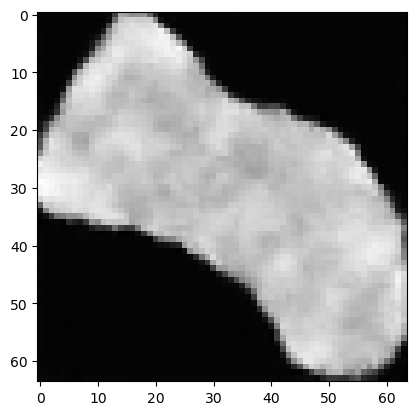

In [21]:
import matplotlib.animation as animation

random_index = 5

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(
        samples[i][random_index].reshape(image_size, image_size, channels),
        cmap="gray",
        animated=True,
    )
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save("diffusion.gif")
plt.show()